<a href="https://colab.research.google.com/github/nhlong1512/IS403.N21/blob/main/Lab5/Lab5_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [83]:
dff = pd.read_excel('VCB.xlsx')
df = dff.loc[::-1].reset_index(drop=True)
print(df)
print(df['Mở'])

                    Ngày  Lần cuối     Mở    Cao   Thấp       KL  % Thay đổi
0    2022-04-01 00:00:00     79000  79000  79400  78000    1.13M      0.0025
1    2022-05-01 00:00:00     78000  79000  80400  78000    1.60M     -0.0127
2    2022-06-01 00:00:00     79100  78600  79900  77900    1.22M      0.0141
3    2022-07-01 00:00:00     79800  79600  79900  78200  966.20K      0.0088
4    2022-10-01 00:00:00     79500  79700  79900  78500    1.10M     -0.0038
..                   ...       ...    ...    ...    ...      ...         ...
333  2023-11-05 00:00:00     90800  92000  92300  90800  460.90K     -0.0077
334  2023-12-05 00:00:00     93000  91500  93000  90800  602.90K      0.0242
335           15/05/2023     91300  92800  93000  91200  419.60K     -0.0183
336           16/05/2023     93000  92000  93100  91100  647.70K      0.0186
337           17/05/2023     92600  92600  93000  92100  501.50K     -0.0043

[338 rows x 7 columns]
0      79000
1      79000
2      78600
3      79600


Kiểm tra tính dừng 
<br/>
**ADF Statistic**: giá trị thống kê của Augmented Dickey-Fuller Test, được sử dụng để kiểm tra tính dừng của chuỗi thời gian. Nếu giá trị này nhỏ hơn các giá trị ngưỡng (được xác định theo mức ý nghĩa của kiểm định), thì có thể kết luận rằng chuỗi thời gian là có tính dừng.


In [84]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Mở'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.456831
p-value: 0.554748


Vì p-values > 0.05 nên chúng ta sẽ thực hiện sai phân xem biểu đồ tương quan hoạt động như thế nào.

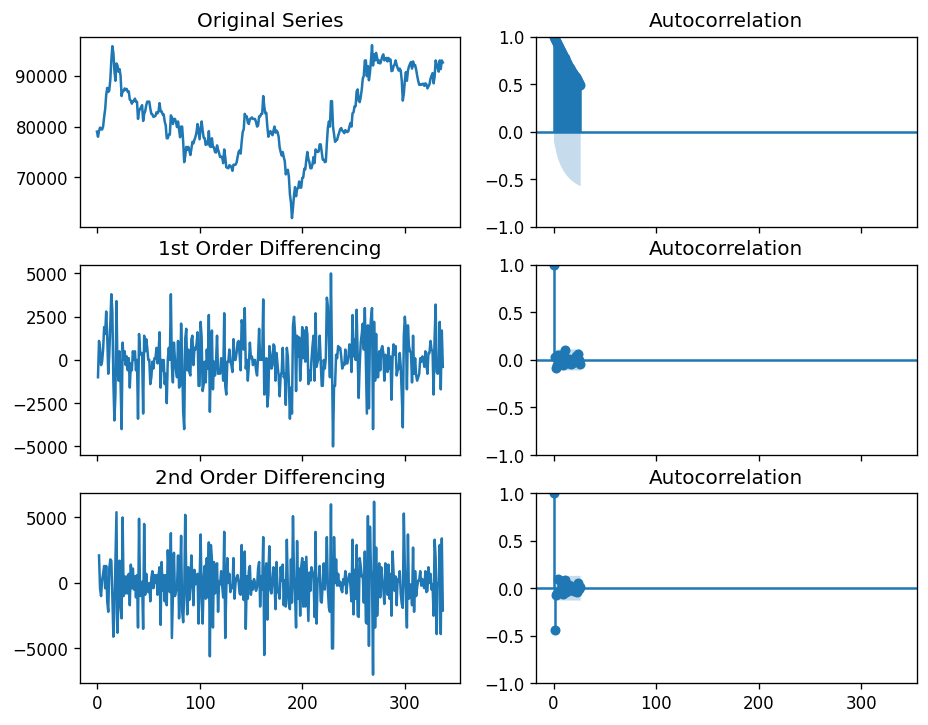

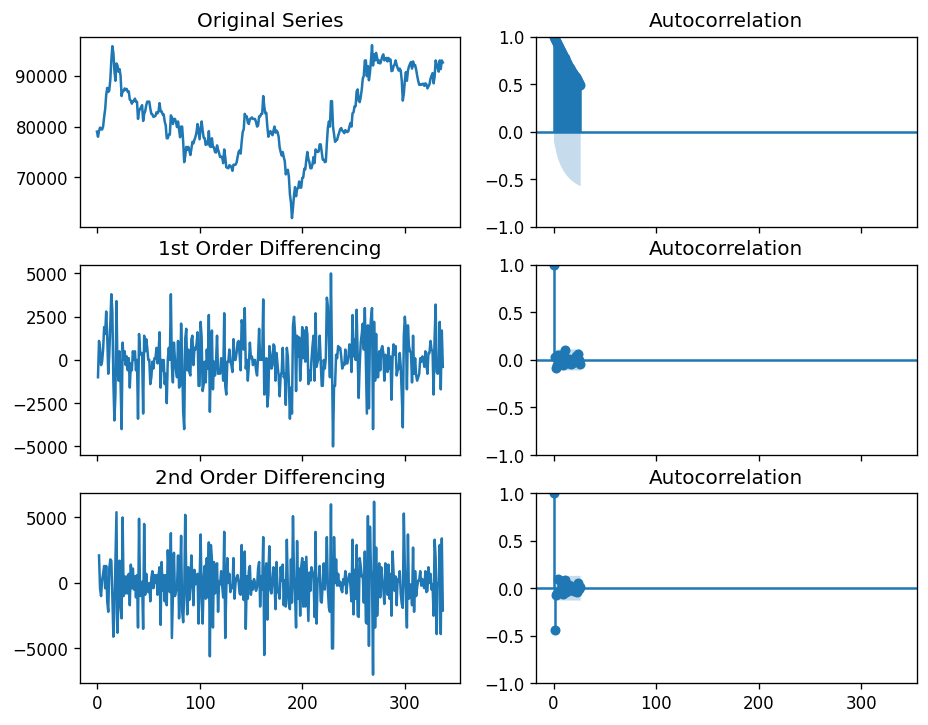

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Lần cuối']); axes[0, 0].set_title('Original Series')
plot_acf(df['Lần cuối'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Lần cuối'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Lần cuối'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Lần cuối'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Lần cuối'].diff().diff().dropna(), ax=axes[2, 1])



**<h3>Xác định p (AR) dựa trên PACF</h3>**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


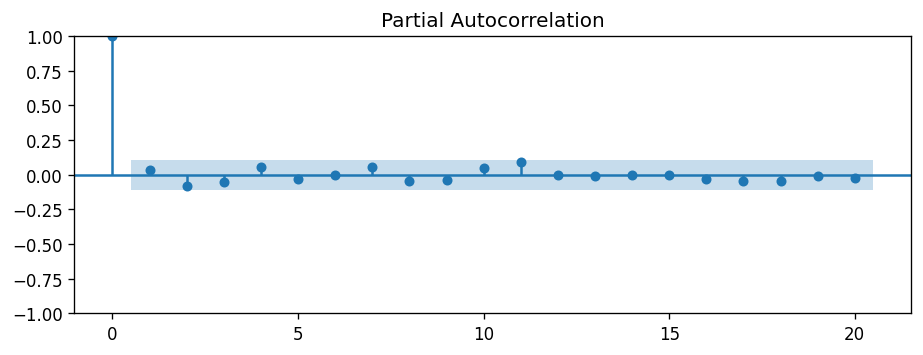

In [86]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df['Lần cuối'].diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,5))
# plot_pacf(df['Lần cuối'].diff().dropna(), ax=axes[1])
plot_pacf(df['Lần cuối'].diff().dropna(), lags=20)
plt.show()

**<h3>Xác định q (MA) dựa trên ACF</h3>**

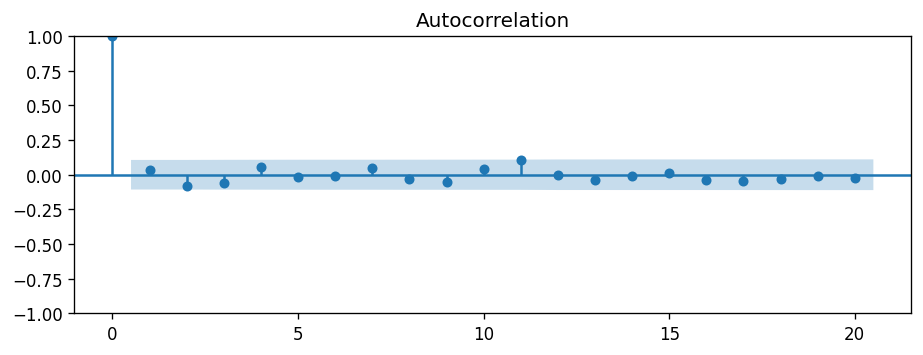

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df['Lần cuối'].diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,1.2))
# plot_acf(df['Lần cuối'].diff().dropna(), ax=axes[1])


# Vẽ ACF plot với 20 lags
plot_acf(df['Lần cuối'].diff().dropna(), lags=20)
plt.show()

plt.show()

In [88]:
# 2. Đọc file dữ liệu chứng khoán và chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [89]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Lần cuối'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4111.307, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4103.314, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4105.321, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4105.313, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4101.317, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4107.316, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [91]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Lần cuối'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Lần cuối'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [92]:
# 6. Quá trình tạo index predict 6 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+6, step=1)

# Create an array of 6 consecutive integers starting from last_index
x_next_6_days = np.array(range(last_index+1, last_index+7)).reshape(-1, 1)

# Predict the closing prices for the next 6 days
y_next_6_days = model.predict(n_periods=len(x_next_6_days))

# Print the predicted closing prices for the next 6 days
print('Predicted closing prices for the next 6 days:')
print(y_next_6_days)

Predicted closing prices for the next 6 days:
[78200. 78200. 78200. 78200. 78200. 78200.]


Validation RMSE: 12279.80921210563
Testing RMSE: 11499.435417679128


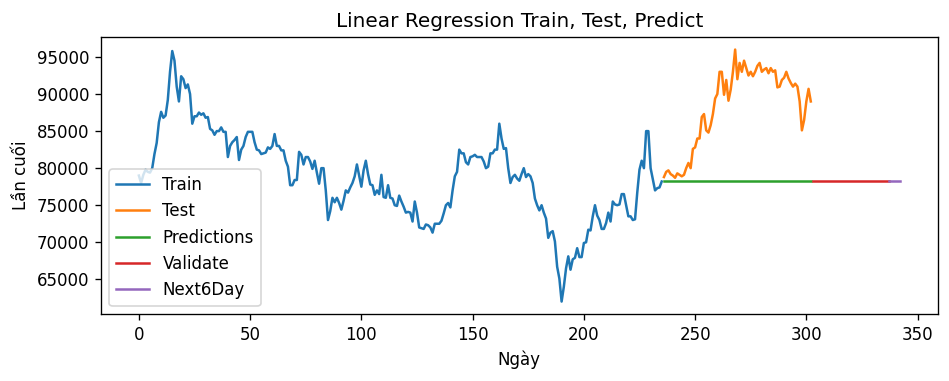

In [93]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.ylabel('Lần cuối');
plt.xlabel('Ngày');
plt.title('Linear Regression Train, Test, Predict')
plt.plot(train_data.index, train_data['Lần cuối'])
plt.plot(test_data.index, test_data['Lần cuối'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_6_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next6Day'])
plt.show()

In [94]:
test_data.index

RangeIndex(start=236, stop=303, step=1)